In [10]:
import os
import time
import math
import random
import datetime
from pathlib import Path
# !pip install transformers
# os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"  # reduce the amount of console output from TF
import tensorflow as tf
from transformers import *
# !pip install -q datasets # install HF datasets library
from datasets import load_dataset
import torch

import logging
# logging.set_verbosity_warning()
# logging.set_verbosity_error()

/opt/conda/lib/python3.7/site-packages/transformers/generation_utils.py:27: FutureWarning: Importing `GenerationMixin` from `src/transformers/generation_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import GenerationMixin` instead.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/transformers/generation_tf_utils.py:27: FutureWarning: Importing `TFGenerationMixin` from `src/transformers/generation_tf_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import TFGenerationMixin` instead.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /opt/conda/lib/python3.7/site-packages/torchvision/image.so: undefined symbol: _ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIlEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  warn(f"Failed to load image Python e

In [4]:
print('TF version',tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU'))) # check GPU available

TF version 2.11.0
Num GPUs Available:  0


2023-04-17 01:14:57.469812: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-04-17 01:14:57.470518: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-17 01:14:57.470539: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (deeplearning-1-vm): /proc/driver/nvidia/version does not exist


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# Load Dataset

In [11]:
dataset_full = load_dataset("mbpp")

  0%|          | 0/4 [00:00<?, ?it/s]

In [12]:
test_set = dataset_full['test']

# Model codeGen

Paper: https://arxiv.org/pdf/2303.16749.pdf

In [62]:
tokenizer = AutoTokenizer.from_pretrained("Salesforce/codegen-6B-mono")

loading file vocab.json from cache at /home/jupyter/.cache/huggingface/hub/models--Salesforce--codegen-6B-mono/snapshots/86e5d4ccee4e2d505c4bf2bb33c456a64be00a7d/vocab.json
loading file merges.txt from cache at /home/jupyter/.cache/huggingface/hub/models--Salesforce--codegen-6B-mono/snapshots/86e5d4ccee4e2d505c4bf2bb33c456a64be00a7d/merges.txt
loading file tokenizer.json from cache at /home/jupyter/.cache/huggingface/hub/models--Salesforce--codegen-6B-mono/snapshots/86e5d4ccee4e2d505c4bf2bb33c456a64be00a7d/tokenizer.json
loading file added_tokens.json from cache at /home/jupyter/.cache/huggingface/hub/models--Salesforce--codegen-6B-mono/snapshots/86e5d4ccee4e2d505c4bf2bb33c456a64be00a7d/added_tokens.json
loading file special_tokens_map.json from cache at /home/jupyter/.cache/huggingface/hub/models--Salesforce--codegen-6B-mono/snapshots/86e5d4ccee4e2d505c4bf2bb33c456a64be00a7d/special_tokens_map.json
loading file tokenizer_config.json from cache at /home/jupyter/.cache/huggingface/hub/m

In [63]:
model = AutoModelForCausalLM.from_pretrained("Salesforce/codegen-6B-mono").to(device);

loading configuration file config.json from cache at /home/jupyter/.cache/huggingface/hub/models--Salesforce--codegen-6B-mono/snapshots/86e5d4ccee4e2d505c4bf2bb33c456a64be00a7d/config.json
Model config CodeGenConfig {
  "_name_or_path": "Salesforce/codegen-6B-mono",
  "activation_function": "gelu_new",
  "architectures": [
    "CodeGenForCausalLM"
  ],
  "attn_pdrop": 0.0,
  "bos_token_id": 1,
  "embd_pdrop": 0.0,
  "eos_token_id": 50256,
  "gradient_checkpointing": false,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "codegen",
  "n_ctx": 2048,
  "n_embd": 4096,
  "n_head": 16,
  "n_inner": null,
  "n_layer": 33,
  "n_positions": 2048,
  "resid_pdrop": 0.0,
  "rotary_dim": 64,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 

loading weights file pytorch_model.bin from cache at /home/jupyter/.cache/huggingface/hub/models--Salesforce--codegen-6B-mono/snapshots/86e5d4ccee4e2d505c4bf2bb33c456a64be00a7d/pytorch_model.bin
Generate config GenerationConfig {
  "_from_model_config": true,
  "bos_token_id": 1,
  "eos_token_id": 50256,
  "transformers_version": "4.28.1"
}



RuntimeError: [enforce fail at alloc_cpu.cpp:75] err == 0. DefaultCPUAllocator: can't allocate memory: you tried to allocate 268435456 bytes. Error code 12 (Cannot allocate memory)

- Example 1: One-shot

In [118]:
text = '''Write a python function to remove first and last occurrence of a given character from the string.\n>>> Example: remove_Occ("hello","l") == "heo"'''

In [119]:
print(text)

Write a python function to remove first and last occurrence of a given character from the string.
>>> Example: remove_Occ("hello","l") == "heo"


In [120]:
text_input = text
inputs = tokenizer(text_input, return_tensors="pt")
sample = model.generate(**inputs, max_length=128)

Generate config GenerationConfig {
  "_from_model_config": true,
  "bos_token_id": 1,
  "eos_token_id": 50256,
  "transformers_version": "4.28.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [121]:
output = tokenizer.decode(sample[0], skip_special_tokens=True)

In [122]:
print(output)

Write a python function to remove first and last occurrence of a given character from the string.
>>> Example: remove_Occ("hello","l") == "heo"

"""

def remove_Occ(str, ch):
    return str.replace(ch, "")

print(remove_Occ("hello", "l"))
print(remove_Occ("hello", "o"))
print(remove_Occ("hello", "h"))
print(remove_Occ("hello", "e"))
print(remove_Occ("hello", "l"))
print(remove_Occ("


- Example Few-Shot

In [70]:
text = '''Write a python function to remove first and last occurrence of a given character from the string.\n>>> Example: remove_Occ("hello","l") == "heo"\nremove_Occ("abcda","a") == "bcd"\nremove_Occ("PHP","P") == "H"'''

In [71]:
print(text)

Write a python function to remove first and last occurrence of a given character from the string.
>>> Example: remove_Occ("hello","l") == "heo"
remove_Occ("abcda","a") == "bcd"
remove_Occ("PHP","P") == "H"


In [72]:
text_input = text
inputs = tokenizer(text_input, return_tensors="pt")
sample = model.generate(**inputs, max_length=128)

Generate config GenerationConfig {
  "_from_model_config": true,
  "bos_token_id": 1,
  "eos_token_id": 50256,
  "transformers_version": "4.28.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [73]:
output = tokenizer.decode(sample[0], skip_special_tokens=True)

In [74]:
print(output)

Write a python function to remove first and last occurrence of a given character from the string.
>>> Example: remove_Occ("hello","l") == "heo"
remove_Occ("abcda","a") == "bcd"
remove_Occ("PHP","P") == "H"
remove_Occ("abcda","z") == "abcda"
remove_Occ("abcda","z") == "abcda"
remove_Occ("abcda","z") == "abcda"
remove_Occ("abcda","z") == "abcda"
remove_Occ


In [59]:
print(output)

Write a python function to remove first and last occurrence of a given character from the string.
>>> Example: remove_Occ("hello","l") == "heo"
remove_Occ("abcda","a") == "bcd"
remove_Occ("PHP","P") == "H"
remove_Occ("abcda","z") == "abcda"
remove_Occ("abcda","z") == "abcda"
remove_Occ("abcda","z") == "abcda"
remove_Occ("abcda","z") == "abcda"
remove_Occ


- Example Zero-Shot

In [75]:
text = '''Write a python function to remove first and last occurrence of a given character from the string.'''

In [76]:
text_input = text
inputs = tokenizer(text_input, return_tensors="pt")
sample = model.generate(**inputs, max_length=128)

Generate config GenerationConfig {
  "_from_model_config": true,
  "bos_token_id": 1,
  "eos_token_id": 50256,
  "transformers_version": "4.28.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [77]:
output = tokenizer.decode(sample[0], skip_special_tokens=True)

# Prediction

In [80]:
import csv
import pandas as pd
import os

In [111]:
def make_prediction(model, input_ids: list, max_length=128, batch=False,**kwargs):
    outputs = model.generate(input_ids, max_length=max_length, **kwargs)
    if batch:
        outputs = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    else:
        outputs = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return outputs

In [82]:
def save_output(output_file: str, data: list, header):
  # Create file if it doesn't exist
  if not os.path.exists(output_file):
    with open(output_file, "a+", encoding='utf-8') as f:
        write = csv.writer(f)
        write.writerows([header])
  results_df = pd.DataFrame.from_records(data, columns=header)
  results_df.to_csv(output_file, mode='a', index=False, header=None)

- Single Prediction: 3 Tests

In [112]:
def format_input(text: str, test_list: list) -> str:
    '''Example:
    Inputs:
    - text: 'Write a python function to remove first and last occurrence of a given character from the string.'
    - test_list: ['assert remove_Occ("hello","l") == "heo"', 'assert remove_Occ("abcda","a") == "bcd"', 'assert remove_Occ("PHP","P") == "H"']
    Output:
        Write a python function to remove first and last occurrence of a given character from the string.
        >>> Example: remove_Occ("hello","l") == "heo"
        >>> Example: remove_Occ("abcda","a") == "bcd"
        >>> Example: remove_Occ("PHP","P") == "H"
    '''
    test_list_processed = ['\n>>> Example: ' + test.split('assert ')[1] for test in test_list]
    text_input = text + ''.join(test_list_processed)
    return text_input

In [115]:
# MAX_LENGTH = 1331
results = []
# list_of_inputs = []
# list_of_true_labels = []
# list_of_predictions = []
full_path = 'outputs'
model_name = 'codegen-6B-mono'
output_file = f"{full_path}/{model_name}-pred.csv"
for sample in test_set:
    task_id = sample['task_id']
    example = sample['text']
    true_label = sample['code']
    max_length = len(true_label)
    inputs = format_input(example, sample['test_list'])
    model_inputs = tokenizer(inputs, return_tensors="pt") # prediction with same lengh as output
    output = make_prediction(model, model_inputs.input_ids, max_length=max_length)
      # list_of_inputs.append([inputs]) 
      # list_of_predictions.append([output])
      # list_of_true_labels.append([true_label])
    result = [{'task_id': task_id, 'text': example, 'test_list': sample['test_list'],
                 'input': inputs, 'true_label': true_label, 'prediction': output}]
    results.append(result)
    save_output(output_file, result, header=['task_id', 'text', 'test_list',
             'input', 'true_label', 'prediction'])
  # break

- Single Prediction: 1 Example

In [ ]:
# test_set[0]

In [159]:
# MAX_LENGTH = 1331
results = []
# list_of_inputs = []
# list_of_true_labels = []
# list_of_predictions = []
full_path = 'outputs'
model_name = 'codegen-6B-mono'
output_file = f"{full_path}/{model_name}-pred-1example.csv"
for sample in test_set:
    # print(sample)
    # print(sample)
    task_id = sample['task_id']
    if task_id <= 15:
        continue
    example = sample['text']
    true_label = sample['code']
    max_length = len(true_label)
    inputs = format_input(example, [sample['test_list'][0]]) # passing only one example
    model_inputs = tokenizer(inputs, return_tensors="pt") # prediction with same lengh as output
    output = make_prediction(model, model_inputs.input_ids, max_length=max_length)
      # list_of_inputs.append([inputs]) 
      # list_of_predictions.append([output])
      # list_of_true_labels.append([true_label])
    result = [{'task_id': task_id, 'text': example, 'test_list': sample['test_list'],
                 'input': inputs, 'true_label': true_label, 'prediction': output}]
    results.append(result)
    save_output(output_file, result, header=['task_id', 'text', 'test_list',
             'input', 'true_label', 'prediction'])
  # break

Generate config GenerationConfig {
  "_from_model_config": true,
  "bos_token_id": 1,
  "eos_token_id": 50256,
  "transformers_version": "4.28.1"
}

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Generate config GenerationConfig {
  "_from_model_config": true,
  "bos_token_id": 1,
  "eos_token_id": 50256,
  "transformers_version": "4.28.1"
}

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Generate config GenerationConfig {
  "_from_model_config": true,
  "bos_token_id": 1,
  "eos_token_id": 50256,
  "transformers_version": "4.28.1"
}

The attention mask and the pad token id were not se

KeyboardInterrupt: 

- Multiple Predictions (num_return_sequences)

In [184]:
print('Model on GPU?: ', next(model.parameters()).is_cuda)

Model on GPU?:  False


In [185]:
# MAX_LENGTH = 1331
results = []
# list_of_inputs = []
# list_of_true_labels = []
# list_of_predictions = []
full_path = 'outputs'
model_name = 'codegen-6B-mono-multiple-outputs'
output_file = f"{full_path}/{model_name}-pred.csv"
for sample in test_set:
    task_id = sample['task_id']
    example = sample['text']
    true_label = sample['code']
    max_length = len(true_label)
    inputs = format_input(example, [sample['test_list'][0]]) # passing only one example
    model_inputs = tokenizer(inputs, return_tensors="pt").to(device) # prediction with same lengh as output
    output = make_prediction(model, model_inputs.input_ids, max_length=max_length, batch=True,
                           num_beams=80, num_return_sequences=80, early_stopping=True)
    del model_inputs
  # list_of_inputs.append([inputs]) 
  # list_of_predictions.append([output])
  # list_of_true_labels.append([true_label])
    result = [{'task_id': task_id, 'text': example, 'test_list': sample['test_list'],
             'input': inputs, 'true_label': true_label, 'prediction': output}]
    # results.append(result)
    save_output(output_file, result, header=['task_id', 'text', 'test_list',
             'input', 'true_label', 'prediction'])

Generate config GenerationConfig {
  "_from_model_config": true,
  "bos_token_id": 1,
  "eos_token_id": 50256,
  "transformers_version": "4.28.1"
}

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


RuntimeError: [enforce fail at alloc_cpu.cpp:75] err == 0. DefaultCPUAllocator: can't allocate memory: you tried to allocate 28672000 bytes. Error code 12 (Cannot allocate memory)

# Evaluation

In [163]:
# import nltk
# from nltk.tokenize import word_tokenize
# from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import numpy as np
import pandas as pd
import logging

logger = logging.getLogger('Evaluation')

logger.setLevel(logging.DEBUG)# allow DEBUG level messages to pass through the logger

- Synthesis Performance

In [164]:
df = pd.read_csv('outputs/codegen-6B-mono-pred-1example.csv')

In [166]:
rows = df[['task_id', 'test_list','true_label', 'prediction']].values

In [167]:
acc_list = []
error_messages = []
result = []
logger.info('Starting loop')

for i, row in enumerate(rows):
    task_id, test_list, true_label, prediction = row
    logger.info(f'Processing item {i+1} of {len(rows)}. Task_id: {task_id}')
    test_list = eval(test_list) # evaluate the string representation of each list as a Python expression
    # Get code after 'def'
    def_index = prediction.find('def')  # find the index of the 'def' keyword
    function_def = prediction[def_index:]  # extract the substring starting from 'def'

    error_list = []
    count_success = 0
    try:
      # if task_id != 45:   
      exec(function_def)
      for i, test in enumerate(test_list):
        try:
          exec(test)
          error_list.append(f'Test {i} Success')
          count_success += 1
        except Exception as e:
          # print(type(e))
          error_list.append(f'Test {i} {type(e)}: {e}')
      # else:
      #   error_list.append(f"Test {i}: <class \'RecursionError\'>: maximum recursion depth exceeded in comparison")

    except Exception as e:
        error_list.append(f'{type(e)}: {e}')
    acc_list.append(count_success/len(test_list))
    error_messages.append(error_list)
    result.append(
      {'task_id': task_id, 'test_list': test_list, 'true_label': true_label,
       'prediction': prediction, 'successful_test_cases': count_success,
       'error_list': error_list})

INFO:Evaluation:Starting loop
INFO:Evaluation:Processing item 1 of 106. Task_id: 11
INFO:Evaluation:Processing item 2 of 106. Task_id: 12
INFO:Evaluation:Processing item 3 of 106. Task_id: 13
INFO:Evaluation:Processing item 4 of 106. Task_id: 14
INFO:Evaluation:Processing item 5 of 106. Task_id: 15
INFO:Evaluation:Processing item 6 of 106. Task_id: 16
INFO:Evaluation:Processing item 7 of 106. Task_id: 17
INFO:Evaluation:Processing item 8 of 106. Task_id: 11
INFO:Evaluation:Processing item 9 of 106. Task_id: 16
INFO:Evaluation:Processing item 10 of 106. Task_id: 17
INFO:Evaluation:Processing item 11 of 106. Task_id: 18
INFO:Evaluation:Processing item 12 of 106. Task_id: 19
INFO:Evaluation:Processing item 13 of 106. Task_id: 20
INFO:Evaluation:Processing item 14 of 106. Task_id: 21
INFO:Evaluation:Processing item 15 of 106. Task_id: 22
INFO:Evaluation:Processing item 16 of 106. Task_id: 23
INFO:Evaluation:Processing item 17 of 106. Task_id: 24
INFO:Evaluation:Processing item 18 of 106. T

heo
hell
ello
hllo
heo
heo
heo
heo
heo
heo
heo
heo
heo
heo
heo
heo
heo
heo
heo
hell
ello
hllo
heo
heo
heo
heo
heo
heo
heo
heo
heo
heo
heo
heo
heo
heo
bacuve
False
False
4


Enter a decimal number:  


INFO:Evaluation:Processing item 27 of 106. Task_id: 34
INFO:Evaluation:Processing item 28 of 106. Task_id: 35
INFO:Evaluation:Processing item 29 of 106. Task_id: 36
INFO:Evaluation:Processing item 30 of 106. Task_id: 37
INFO:Evaluation:Processing item 31 of 106. Task_id: 38
INFO:Evaluation:Processing item 32 of 106. Task_id: 39
INFO:Evaluation:Processing item 33 of 106. Task_id: 40
INFO:Evaluation:Processing item 34 of 106. Task_id: 41
INFO:Evaluation:Processing item 35 of 106. Task_id: 42
INFO:Evaluation:Processing item 36 of 106. Task_id: 43
INFO:Evaluation:Processing item 37 of 106. Task_id: 44
INFO:Evaluation:Processing item 38 of 106. Task_id: 45
INFO:Evaluation:Processing item 39 of 106. Task_id: 46
INFO:Evaluation:Processing item 40 of 106. Task_id: 47
INFO:Evaluation:Processing item 41 of 106. Task_id: 48
INFO:Evaluation:Processing item 42 of 106. Task_id: 49
INFO:Evaluation:Processing item 43 of 106. Task_id: 50
INFO:Evaluation:Processing item 44 of 106. Task_id: 51
INFO:Evalu

16


INFO:Evaluation:Processing item 48 of 106. Task_id: 55
INFO:Evaluation:Processing item 49 of 106. Task_id: 56
INFO:Evaluation:Processing item 50 of 106. Task_id: 57
INFO:Evaluation:Processing item 51 of 106. Task_id: 58
INFO:Evaluation:Processing item 52 of 106. Task_id: 59
INFO:Evaluation:Processing item 53 of 106. Task_id: 60
INFO:Evaluation:Processing item 54 of 106. Task_id: 61
INFO:Evaluation:Processing item 55 of 106. Task_id: 62
INFO:Evaluation:Processing item 56 of 106. Task_id: 63
INFO:Evaluation:Processing item 57 of 106. Task_id: 64
INFO:Evaluation:Processing item 58 of 106. Task_id: 65
INFO:Evaluation:Processing item 59 of 106. Task_id: 66
INFO:Evaluation:Processing item 60 of 106. Task_id: 67
INFO:Evaluation:Processing item 61 of 106. Task_id: 68
INFO:Evaluation:Processing item 62 of 106. Task_id: 69
INFO:Evaluation:Processing item 63 of 106. Task_id: 70
INFO:Evaluation:Processing item 64 of 106. Task_id: 71
INFO:Evaluation:Processing item 65 of 106. Task_id: 72
INFO:Evalu

[('Maths', 97), ('Science', 90), ('English', 88), ('Social sciences', 82)]
[5, 15, 25, 37, 79]
False
False
[(7, 1), (8, 5), (4, 6)]
{1: 1, 2: 3, 3: 1, 4: 1, 5: 2, 6: 1, 7: 1, 8: 1, 9: 1}
-1


In [169]:
output_file = "outputs/codegen-6B-mono-eval.csv"
save_output(output_file, result, header=['task_id', 'test_list', 'true_label',
       'prediction', 'successful_test_cases',
       'error_list'])

### Pass @k

The pass@k is the fraction of prompts for which the model succeeded in this sense.

For example, if Pass@5 is 80%, it means that for 80% of the queries, the system returned at least one relevant document among the top 5 results.

It robustly estimates the probability that one of k generations passes the tests

Reference: https://twitter.com/lvwerra/status/1474072790785564673

In [ ]:
!pip install evaluate

In [187]:
from evaluate import load

ModuleNotFoundError: No module named 'evaluate'

In [189]:
def compute_pass_k_metric(test_cases: list, candidates: list, k: list) -> tuple:
  '''The Code Eval metric calculates how good are predictions given a set of references
  https://huggingface.co/spaces/evaluate-metric/code_eval

  Args:
    test_cases
    candidates
    k
  Returns:
    (dict, dict)
  '''
  # Join test cases into a single string.
  test_cases_joined = ['\n'.join(test) for test in test_cases]
  pass_at_k, results = code_eval.compute(references=test_cases_joined, predictions=candidates, k=k)
  return pass_at_k, results

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/CSCI544/Project/codet5-large-ntp-py-multiple-sentences-pred.csv')a

In [ ]:
df = df.drop_duplicates(subset=['task_id'])

In [ ]:
code_eval = load("code_eval")

In [ ]:
def post_processing(prediction: list) -> list:
  '''Get string after 'def' statement
  '''
  output = []
  for pred in prediction:
      def_index = pred.find('def') # get only function
      output.append(pred[def_index:])
  return output

In [ ]:
# Clean output
df['prediction_cleaned'] = df['prediction'].apply(lambda x: post_processing(eval(x)))

In [ ]:
pass_k_test = []
pass_k_predictions = []
for test, pred in zip(df['test_list'], df['prediction_cleaned']):
    pass_k_test.append(eval(test))
    pass_k_predictions.append(pred)

In [ ]:
%%time
pass_at_k, results = compute_pass_k_metric(pass_k_test, pass_k_predictions, [1,2,5,80])

In [ ]:
import json

# as requested in comment
results = {'results': results}

with open('outputs/code_gen_pass_k_metric_results.txt', 'w') as file:
     file.write(json.dumps(results))

### What sort of errors the model makes?

According to "CodeRL: Mastering Code Generation through Pretrained Models and Deep Reinforcement Learning" paper, we can classify the error in 4 different categories:
- "Compile Error"
- "Runtime Error"
- "Failed Test"
- "Passed Test"

In [171]:
from collections import Counter

In [172]:
df_eval = pd.read_csv('outputs/codegen-6B-mono-eval.csv')

In [175]:
def retrieve_error_message(error_string: str) -> str or None:
    '''Retrieve error type form string, 
     return None if not found
     '''
    try:
        start_index = error_string.index("<class '") + len("<class '")
        end_index = error_string.index("'>:")
        assertion_error_str = error_string[start_index:end_index]
    except:
        # if no error is found, search for success
        if 'Success' in error_string:
            assertion_error_str = 'Success'  
        # Should never happen
        # else:
        #   print(error_string)
        #   assertion_error_str = None
    return assertion_error_str

In [177]:
errors = []
for _, list_of_errors in enumerate(df_eval['error_list'].values):
    tmp = set([retrieve_error_message(error_message) for error_message in eval(list_of_errors)])
    # tmp_count = Counter(tmp)
    errors.append(tmp)

In [178]:
def classify_errors(errors: set) -> str:
  # Only one type of error
  if len(errors) == 1:
    if 'AssertionError' in errors:
      error_class = 'FailedTest'
    elif 'Success' in errors:
      error_class = 'PassedAllTest'
    elif 'SyntaxError' in errors:
      error_class = 'CompileError'
    else:
      error_class = 'RuntimeError'
  else:
    if 'Success' in errors:
      error_class = 'PassedAtLeastOneTest'
    else:
      error_class = 'RuntimeError'

  return error_class

In [179]:
errors_class = [classify_errors(error) for error in errors]
errors_class = Counter(errors_class)

In [182]:
import builtins
import matplotlib.pyplot as plt
import seaborn as sns

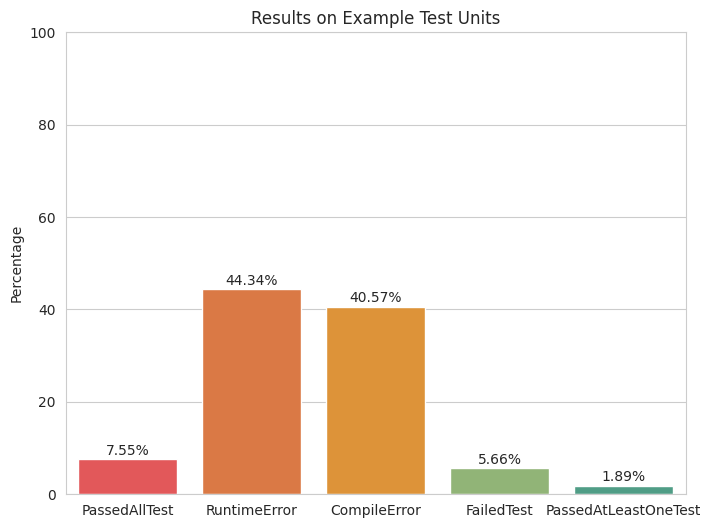

In [183]:
# Calculate the total number of items in the Counter
total = builtins.sum(errors_class.values())

# Calculate the percentage of each item in the Counter
percentages = [(count/total)*100 for count in errors_class.values()]

# Define custom colors
colors = ['#f94144', '#f3722c', '#f8961e', '#90be6d', '#43aa8b']

# Create a Seaborn bar plot
sns.set_style("whitegrid")
plt.figure(figsize=(8, 6))
ax = sns.barplot(x=list(errors_class.keys()), y=percentages, palette=colors)
ax.set_title("Results on Example Test Units")
# ax.set_xlabel("Error Type")
ax.set_ylabel("Percentage")
ax.set_ylim([0, 100])

# Add the percentage values on the bars
for i, v in enumerate(percentages):
    ax.text(i, v + 1, f"{v:.2f}%", ha='center')

plt.show()